## SQUEEZE NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU



from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.9.3


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 2003 images belonging to 4 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2003 images belonging to 4 classes.


In [5]:
def squeezenet(input_shape, n_classes):
  
  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)
  
  output = Activation('softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 4

K.clear_session()
model = squeezenet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 96  14208       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 96)   0           ['conv2d[0][0]']                 
                                                                                              

In [6]:
model_path = "SQUEEZE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.3869 - accuracy: 0.2396 - precision: 0.0000e+00
Epoch 1: accuracy improved from -inf to 0.23958, saving model to SQUEEZE.h5
3/3 [==============================] - 26s 6s/step - loss: 1.3869 - accuracy: 0.2396 - precision: 0.0000e+00 - val_loss: 1.3842 - val_accuracy: 0.3229 - val_precision: 0.0000e+00
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.3861 - accuracy: 0.2500 - precision: 0.0000e+00
Epoch 2: accuracy improved from 0.23958 to 0.25000, saving model to SQUEEZE.h5
3/3 [==============================] - 15s 5s/step - loss: 1.3861 - accuracy: 0.2500 - precision: 0.0000e+00 - val_loss: 1.3906 - val_accuracy: 0.2604 - val_precision: 0.0000e+00
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.2892 - precision: 0.0000e+00
Epoch 3: accuracy improved from 0.25000 to 0.28916, saving model to SQUEEZE.h5
3/3 [==============================] - 24s 9s/step - loss

Epoch 100/100
3/3 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.6875 - precision: 0.6875
Epoch 100: accuracy improved from 0.66667 to 0.68750, saving model to SQUEEZE.h5
3/3 [==============================] - 14s 5s/step - loss: 0.6152 - accuracy: 0.6875 - precision: 0.6875 - val_loss: 0.6722 - val_accuracy: 0.5833 - val_precision: 0.5833


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

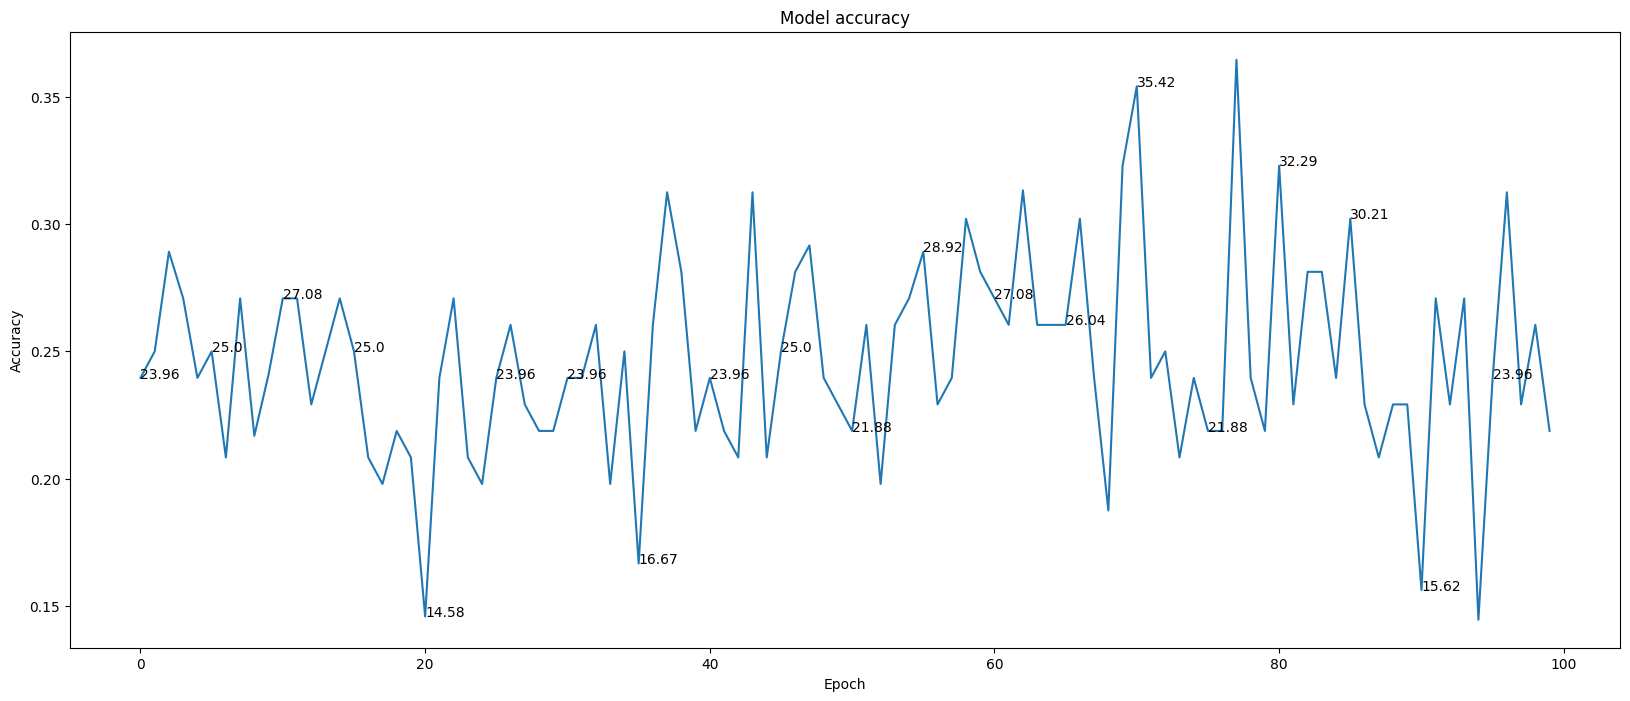

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

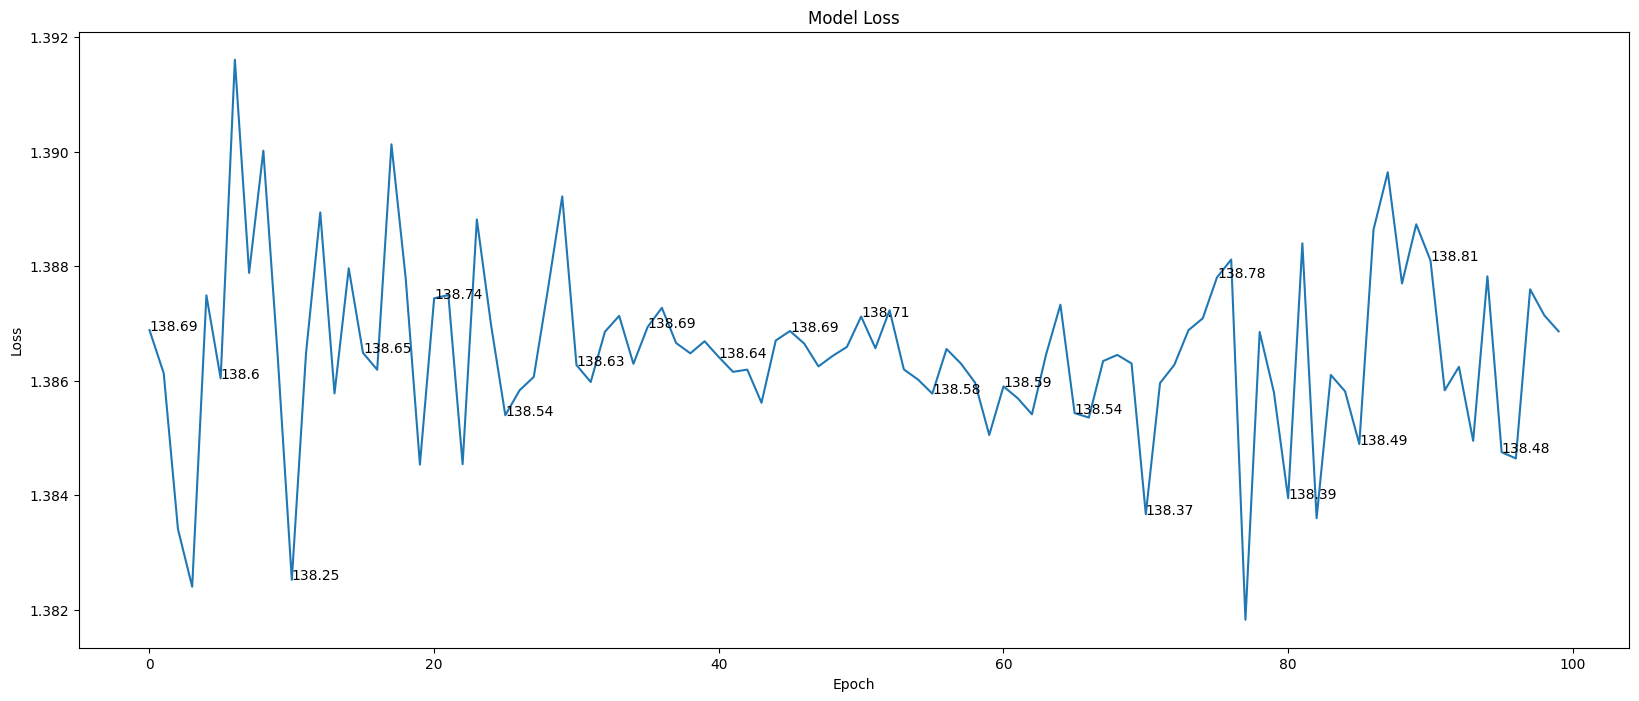

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

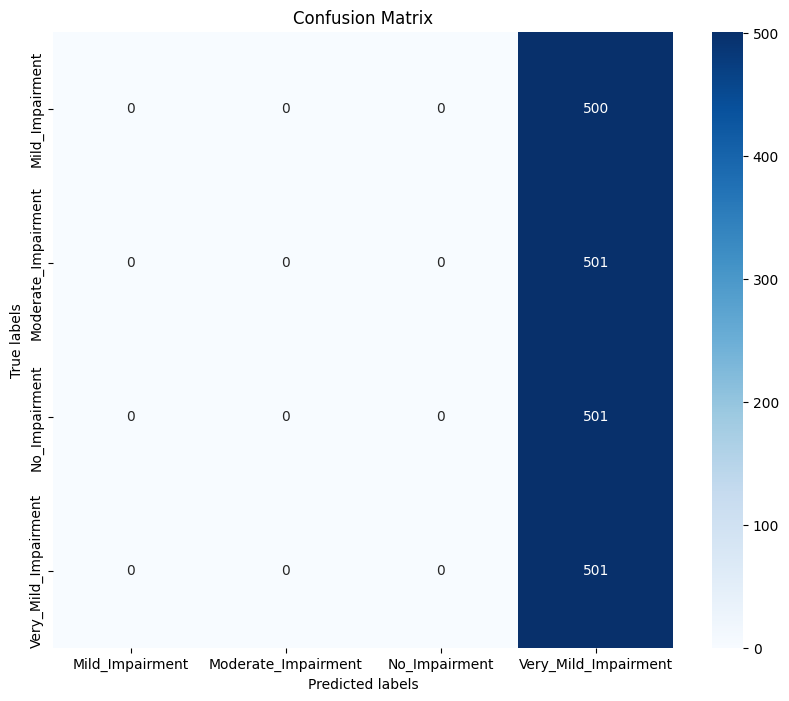

                      precision    recall  f1-score   support

     Mild_Impairment       0.00      0.00      0.00       500
 Moderate_Impairment       0.00      0.00      0.00       501
       No_Impairment       0.00      0.00      0.00       501
Very_Mild_Impairment       0.25      1.00      0.40       501

            accuracy                           0.25      2003
           macro avg       0.06      0.25      0.10      2003
        weighted avg       0.06      0.25      0.10      2003



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_steps = len(test_data)
num_classes = len(train_data.class_indices)

# Generate predictions
predictions = model.predict_generator(test_data, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_labels = [str(key) for key in train_data.class_indices.keys()]
print(classification_report(true_labels, y_pred, target_names=class_labels))